In [1]:
import sys
sys.path.append('/home/student/ROI/SparkProgram')
from initspark import *
sc, spark, conf = initspark()

import pandas as pd
import matplotlib as mp
import numpy
from matplotlib import pyplot as plt
from IPython.display import display


In [2]:
#filename = 'CarLoanDefaults.csv'

filename = 'bank.csv'
df = spark.read.csv(f'/home/student/ROI/Spark/datasets/finance/{filename}', header = True, inferSchema = True)
display(df.limit(10).toPandas())

# Save a pointer to the raw data
df0 = df


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [3]:
def drop_columns(df, collist):
    return df.select([c for c in df.columns if c not in collist])

def auto_numeric_features(df, exceptlist = ()):
    numeric_features = [t[0] for t in df.dtypes if t[0] not in exceptlist and t[1] in ['int', 'double']]
    return numeric_features

def auto_categorical_features(df):
    categorical_features = [c for c in df.columns if c.endswith('_ID') or c.endswith('_FLAG')]
    return categorical_features

def describe_numeric_features(df, numeric_features):
    print(df.select(numeric_features).describe().toPandas().transpose())

    
if filename == 'bank.csv':
    drop_cols = ('day','month')
    target_col = 'deposit'
    categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
elif filename == 'CarLoanDefaults.csv':
    drop_cols = ('UNIQUEID','DATE_OF_BIRTH','DISBURSAL_DATE', 'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'MOBILENO_AVL_FLAG')
    target_col = 'LOAN_DEFAULT'
    categorical_features = auto_categorical_features(df)

df = drop_columns(df, drop_cols)
numeric_features = auto_numeric_features(df, exceptlist = categorical_features)
print (numeric_features)
print ('*' * 80)
describe_numeric_features(df, numeric_features)
print ('*' * 80)

# save a pointer to the fixed data
df1 = df


['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
********************************************************************************
              0                   1                   2      3      4
summary   count                mean              stddev    min    max
age       11162  41.231947679627304  11.913369192215518     18     95
balance   11162  1528.5385235620856   3225.413325946149  -6847  81204
duration  11162  371.99381831213043  347.12838571630687      2   3881
campaign  11162   2.508421429851281  2.7220771816614824      1     63
pdays     11162   51.33040673714388  108.75828197197717     -1    854
previous  11162  0.8325568894463358   2.292007218670508      0     58
********************************************************************************


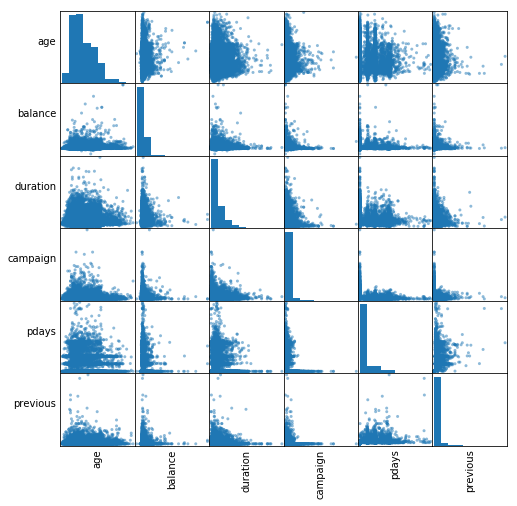

In [4]:
%matplotlib inline
def scatter_matrix(df, numeric_features):
    numeric_data = df.select(numeric_features).toPandas()
    axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
    n = len(numeric_data.columns)
    for i in range(n):
        v = axs[i, 0]
        v.yaxis.label.set_rotation(0)
        v.yaxis.label.set_ha('right')
        v.set_yticks(())
        h = axs[n-1, i]
        h.xaxis.label.set_rotation(90)
        h.set_xticks(())
        
scatter_matrix(df, numeric_features)

In [5]:
def fix_categorical_data(df, categorical_features, target_col):
    from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
    from pyspark.ml import Pipeline

    stages = []

    for c in categorical_features:
        stringIndexer = StringIndexer(inputCol = c, outputCol = c + 'Index')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[c + "classVec"])
        stages += [stringIndexer, encoder]

    label_stringIdx = StringIndexer(inputCol = target_col, outputCol = 'label')
    stages += [label_stringIdx]

    assemblerInputs = [c + "classVec" for c in categorical_features] + numeric_features
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]

    cols = df.columns
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    dfx = pipelineModel.transform(df)
    dfx = dfx.select(['label', 'features'] + cols)
    return dfx

df = fix_categorical_data(df, categorical_features, target_col)
# save a pointer to this stage of the dataframe
df2 = df

df.printSchema()


root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [6]:
df.groupBy('label').count().show()


+-----+-----+
|label|count|
+-----+-----+
|  0.0| 5873|
|  1.0| 5289|
+-----+-----+



In [9]:
pd.DataFrame(df.take(5), columns = df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [10]:
train, test = df.randomSplit([.7,.3], seed = 1000)
print (f'Training set row count {train.count()}')
print (f'Testing set row count {test.count()}')
      

Training set row count 7760
Testing set row count 3402


In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
print('LR Trained')

LR Trained


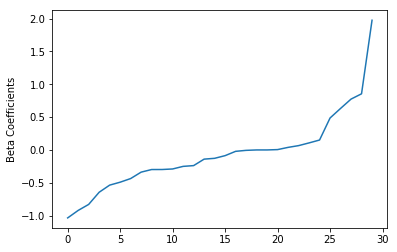

In [12]:
def beta_coefficients(model):
    import matplotlib.pyplot as plt
    import numpy as np
    beta = np.sort(model.coefficients)
    plt.plot(beta)
    plt.ylabel('Beta Coefficients')
    plt.show()
    
beta_coefficients(lrModel)

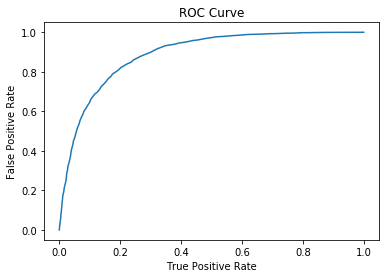

Training set area Under ROC: 0.8876199848145777


In [16]:
def roc_curve(model):
    summary = model.summary
    roc = summary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set area Under ROC: {}'.format(summary.areaUnderROC))

roc_curve(lrModel)

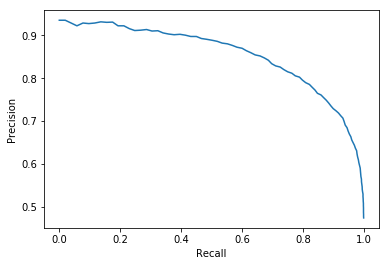

In [17]:
def precision_recall(model):
    summary = model.summary
    pr = summary.pr.toPandas()
    plt.plot(pr['recall'],pr['precision'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

precision_recall(lrModel)    

In [18]:
def evaluate_ROC(predictions):
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator()
    return evaluator.evaluate(predictions)

def show_predictions(predictions, limit = 20):
    print('Test Area Under ROC {}'.format(evaluate_ROC(predictions)))
    predictions.groupBy('prediction').count().show()
    predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(limit)



predictions = lrModel.transform(test)
show_predictions(predictions)


Test Area Under ROC 0.8790833214035488
+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1904|
|       1.0| 1498|
+----------+-----+

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[2.06522739797547...|       0.0|[0.88747724342710...|
|  0.0|[1.51942189802491...|       0.0|[0.82045333636347...|
|  0.0|[2.06036339758888...|       0.0|[0.88699060139817...|
|  0.0|[3.76102651468440...|       0.0|[0.97726887114569...|
|  0.0|[1.47060929207989...|       0.0|[0.81314997776202...|
|  0.0|[1.00566079767295...|       0.0|[0.73217010218998...|
|  0.0|[1.21003749352566...|       0.0|[0.77030558302674...|
|  0.0|[2.80295668775874...|       0.0|[0.94283538897014...|
|  0.0|[-0.8250750145856...|       1.0|[0.30468743835435...|
|  0.0|[1.02042682309600...|       0.0|[0.73505573109278...|
|  0.0|[0.35781792210617...|       0.0|[0.58851211209

In [19]:
def better_collect(df):
    return [tuple(row) if len(tuple(row)) > 1 else tuple(row)[0] for row in df.collect()]

print (better_collect(predictions.select('prediction').distinct()))

def cm_percent(cm, length, legend = True):
    import numpy as np
    x = np.ndarray(shape = (2,2), \
                      buffer = np.array([100 *(cm[0][0] + cm[1][1])/length, \
                      100 * cm[0][1]/length, 100 * cm[1][0]/length, \
                      100 * (cm[1][0] + cm[0][1])/length]))
    return x



[0.0, 1.0]


In [23]:
def evaluate_model(model):
    beta_coefficients(lrModel)
    roc_curve(lrModel)
    precision_recall(lrModel)    

def evaluate_predictions(predictions, show = True):
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
    log = {}

    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['auroc'] = evaluator.evaluate(predictions)  
    
    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['aupr'] = evaluator.evaluate(predictions)

    # Metrics
    predictionRDD = predictions.select(['label', 'prediction']) \
                   .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    

    # Overall statistics
    log['precision'] = metrics.precision()
    log['recall'] = metrics.recall()
    log['F1 Measure'] = metrics.fMeasure()
    
    # Statistics by class
    distinctPredictions = better_collect(predictions.select('prediction').distinct())
    for x in sorted(distinctPredictions):
        log[x] = {}
        log[x]['precision'] = metrics.precision(x)
        log[x]['recall'] = metrics.recall(x)
        log[x]['F1 Measure'] = metrics.fMeasure(x, beta = 1.0)

    # Confusion Matrix
    log['cm'] = metrics.confusionMatrix().toArray()
    log['cmpercent'] = cm_percent(log['cm'], predictions.count(), show)

    if show:
        show_predictions(predictions)

        print("Area under ROC = {}".format(log['auroc']))
        print("Area under AUPR = {}".format(log['aupr']))
        print('\nOverall\ntprecision = {}\nrecall = {}\nF1 Measure = {}\n'.format( 
              log['precision'], log['recall'], log['F1 Measure']))

        for x in sorted(distinctPredictions):
            print('Label {}\ntprecision = {}\nrecall = {}\nF1 Measure = {}\n'.format( 
                  x, log[x]['precision'], log[x]['recall'], log[x]['F1 Measure']))
        
        print ('Confusion Matrix')
        print (log['cm'])
        print (' PC', 'FP\n', 'FN', 'PW')
        print (log['cmpercent'])

    return log    


log = evaluate_predictions(predictions)
print ()
print (log)

Test Area Under ROC 0.8790833214035488
+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1904|
|       1.0| 1498|
+----------+-----+

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[2.06522739797547...|       0.0|[0.88747724342710...|
|  0.0|[1.51942189802491...|       0.0|[0.82045333636347...|
|  0.0|[2.06036339758888...|       0.0|[0.88699060139817...|
|  0.0|[3.76102651468440...|       0.0|[0.97726887114569...|
|  0.0|[1.47060929207989...|       0.0|[0.81314997776202...|
|  0.0|[1.00566079767295...|       0.0|[0.73217010218998...|
|  0.0|[1.21003749352566...|       0.0|[0.77030558302674...|
|  0.0|[2.80295668775874...|       0.0|[0.94283538897014...|
|  0.0|[-0.8250750145856...|       1.0|[0.30468743835435...|
|  0.0|[1.02042682309600...|       0.0|[0.73505573109278...|
|  0.0|[0.35781792210617...|       0.0|[0.58851211209

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)


In [ ]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC: {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))



In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)


In [ ]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC: {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))


In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC: {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print(gbt.explainParams())

## Read in a file to a Spark DataFrame

In [ ]:

from pyspark.ml.feature import StringIndexer
def value_counts(df, cols):
    if len(cols) == 1:
        return tuple(map(tuple, df.groupBy(cols).count().orderBy('count', ascending = False).collect()))
    else:
        return [tuple(map(tuple, df.groupBy(c).count().orderBy('count', ascending = False).collect())) for c in cols]
    #return tuple(adult1.select(col).distinct().collect())

print (value_counts(adult1, ['education']))
print (value_counts(adult1, ['sex', 'race']))



#indexer = StringIndexer(inputCol="workclass", outputCol="workclassindex")
#adult = indexer.fit(adult1).transform(adult1).drop('workclass')
catcols = ['workclass', 'education','maritalstatus','occupation','relationship','race','sex','nativecountry']
#for col in catcols:
#    print(list(adult1.select(col).distinct().collect()))

#StringIndexer(inputCol='workclass', outputCol='workclassindex').fit(adult1).transform(adult1).drop('workclass').show(2)

#for col in catcols:
#    adult2 = StringIndexer(inputCol=col, outputCol=col+"index").fit(adult2).transform(adult2).drop(col)

#adult2.show()


#from pyspark.ml.feature import OneHotEncoderEstimator

#encoder = OneHotEncoderEstimator(inputCols=["workclass", "education"],
#                                 outputCols=["workclassVec", "educationVec"])
#model = encoder.fit(adult1)
#encoded = model.transform(adult1)
#encoded.show()

## Use createOrReplaceTempView to create a virtual table in the Hive catalog and then it can be queried using SQL as if it were a hive table

In [ ]:
territories.createOrReplaceTempView('territories')
t1 =spark.sql('select * from territories where regionid = 1')
t1.show()
print(t1.count())

## Spark DataFrames can be saved to a Hive table using either the saveAsTable method or writing a SQL query that uses CREATE TABLE AS

In [ ]:
! hadoop fs -rm -r /user/hive/warehouse/territories2
! hadoop fs -rm -r /user/hive/warehouse/territories3
! hadoop fs -rm -r /user/hive/warehouse/territoryregion

territories.write.saveAsTable('Territories2', mode='overwrite')
spark.sql('create table Territories3 as select * from territories')

## Queries use standard HQL to mix Hive tables and virtual tables. Both are read into a Spark DataFrame and the processing happens at the Spark level not at the Hive level. HQL is just used to parse the logic into the corresponding Spark methods

In [ ]:
sql = """select r.regionid, r.regionname, t.territoryid, t.territoryname 
from regions as r 
join territories as t on r.regionid = t.regionid 
order by r.regionid, t.territoryid"""
rt = spark.sql(sql)
rt.show(10)

tr = regions.join(territories, regions.regionid == territories.RegionID). \
     select('regions.regionid', 'regionname', 'TerritoryID', 'TerritoryName')
tr.show(10)

## Lab: Read the northwind JSON products and make it into a TempView and do the same with the CSVHeaders version of categories

## Install the MySQL Python connector. This has nothing to do with Spark but if you want to run SQL queries directly it is helpful.

In [ ]:
! pip install mysql-connector-python

## Let's make sure we have a database for northwind and no regions table

In [ ]:
import mysql.connector
try:
    cn = mysql.connector.connect(host='localhost', user='test', password='password')
    cursor = cn.cursor()
    cursor.execute('create database if not exists northwind')
    cn.close()

    cn = mysql.connector.connect(host='localhost', user='test', password='password', database='northwind')
    cursor = cn.cursor()    
    cursor.execute('drop table if exists regions')
    cn.close()
except:
    print('something went wrong')
else:
    print('success')



## Write a DataFrame to a SQL database

In [ ]:
regions.write.format("jdbc").options(url="jdbc:mysql://localhost/northwind", driver='com.mysql.jdbc.Driver', dbtable='regions', user='test', password = "password", mode = "append", useSSL = "false").save()


## Read a SQL table into a Spark DataFrame

In [ ]:
regions2 = spark.read.format("jdbc").options(url="jdbc:mysql://localhost/northwind", driver="com.mysql.jdbc.Driver", dbtable= "regions", user="test", password="password").load()
regions2.show()


## Creating the regions2 DataFrame does not execute anything yet, but by making the DataFrame into a Temp View then running a Spark SQL query, it tells Spark to read the SQL data into a DataFrame and then use the cluster to do the processing, not the SQL source

In [ ]:
regions2.createOrReplaceTempView('regions2')
spark.sql('select * from regions2 where regionid < 3').show()

## Alternate ways to code a query using SQL and methods

In [ ]:
print(spark.sql('select count(*) from regions').collect())
spark.sql('select * from regions').count()

## Using SQL you can use familiar syntax instead of withColumn or withCoumnRenamed methods

In [ ]:
t1 = spark.sql('select TerritoryID as TerrID, UPPER(TerritoryName) as TerritoryName, RegionID from territories')
t1.show(5)

from pyspark.sql.functions import expr
territories.withColumn('TerritoryName', expr('UPPER(TerritoryName)')).withColumnRenamed('TerritoryID', 'TerrID').show(5)

## Sometimes there is a function in Python that doesn't exist in SQL and it would be helpful to use, so you could make a udf and use withColumn

In [ ]:
from pyspark.sql.functions import expr, udf
from pyspark.sql.types import *

t2 = spark.sql('select * from territories')
t2.printSchema()
#t2.show()
t2 = t2.withColumn('upperName', expr('UPPER(TerritoryName)'))
t2.show(5)

t2 = t2.withColumn('titleName', udf(lambda x : x.title(), StringType())(t2.upperName))
t2.show(5)


## To make it easier though, you could make the Python function into a udf that SQL can understand similar to how you can make a DataFrame seem like a virtual table with createOrReplaceTempView

In [ ]:
def reverseString(x):
    return x[::-1]

spark.udf.register('reverse', reverseString, StringType())

spark.sql('select *, reverse(TerritoryName) as Reversed from Territories').orderBy('Reversed').show()

## HQL has collect_set and collect_list functions to aggregate items into a list instead of summing them up 

In [ ]:
from pyspark.sql.functions import collect_list
territories.groupBy(territories.RegionID).agg(collect_list(territories.TerritoryName)).show()

tr1 = spark.sql("SELECT RegionID, collect_list(TerritoryName) AS TerritoryList FROM Territories GROUP BY RegionID")
tr1.show()
tr1.printSchema()
print(tr1.take(1))


## Instead of a simple datatype you could also collect complex structured objects using the HQL NAMED_STRUCT

In [ ]:

sql = """SELECT r.RegionID, r.RegionName
, COLLECT_SET(NAMED_STRUCT("TerritoryID", TerritoryID, "TerritoryName", TerritoryName)) AS TerritoryList
FROM Regions AS r
JOIN Territories AS t ON r.RegionID = t.RegionID
GROUP BY r.RegionID, r.RegionName
ORDER BY r.RegionID"""

tr2 = spark.sql(sql)
tr2.printSchema()
print(tr2)
tr2.show()
print(tr2.take(2))
tr2.write.json('TerritoryRegion.json')
spark.sql('create table TerritoryRegion as ' + sql)

## If you have data that is already collected into a complex datatype and want to flatten it, you could use HQL EXPLODE function

## You could use the Spark explode method

In [ ]:
from pyspark.sql.functions import explode
tr1.select('RegionID', explode('TerritoryList')).show()

## Or if the DataFrame is turned into a Temp View you could use the HQL query to do it

In [ ]:
tr1.createOrReplaceTempView('RegionTerritories')
sql = """SELECT RegionID, TerritoryName
FROM RegionTerritories
LATERAL VIEW EXPLODE(TerritoryList) EXPLODED_TABLE AS TerritoryName
ORDER BY RegionID, TerritoryName
"""
spark.sql(sql).show()

## Or you could select specific elements from a collection

In [ ]:
tr2.createOrReplaceTempView('RegionTerritories')
spark.sql("select RegionId, RegionName, TerritoryList[0] as First, TerritoryList[size(TerritoryList) - 1] as Last, size(TerritoryList) as TerritoryCount from RegionTerritories").show()

## If the array is of structs note the syntax of fetching the elements from the struct uses the . like an object property

In [ ]:
sql = """SELECT RegionID, RegionName, Territory.TerritoryID AS TerritoryID
, Territory.TerritoryName AS TerritoryName
FROM RegionTerritories
LATERAL VIEW EXPLODE(TerritoryList) EXPLODED_TABLE AS Territory
"""
spark.sql(sql).show()

## Homework ##

** First Challenge **
Create a Python function to determine if a number is odd or even and use that to select only the even numbered shippers from the TSV folder of northwind. Note the TSV file does not have headers so you will need to do something to make the DataFrame have a meaningful structure. I would suggest using SparkSql as much as possible to rename and cast the columns which are ShipperID, CompanyName and Phone

** Second Challenge **
Take the Order_LineItems.json folder, read it into a DataFrame and flatten it and then calculate the average price paid for a product.



In [ ]:
# Read the following code and see how it will shape order line items into the order header record
# You will use the result of this saved file for the second challenge
o = spark.read.csv('/home/student/ROI/Spark/datasets/northwind/CSVHeaders/orders', header = True, inferSchema = True)
od = spark.read.csv('/home/student/ROI/Spark/datasets/northwind/CSVHeaders/orderdetails', header = True, inferSchema = True)

o.createOrReplaceTempView('Orders')
od.createOrReplaceTempView('OrderDetails')
sql = """
select o.OrderID, o.CustomerID, o.OrderDate
           , COLLECT_SET(NAMED_STRUCT("ProductID", od.ProductID, 
                                      "UnitPrice", od.UnitPrice,
                                      "Quantity", od.Quantity,
                                      "Discount", od.discount)) as LineItems
from Orders as o join OrderDetails as od on o.OrderID = od.OrderID
GROUP BY o.OrderID, o.CustomerID, o.OrderDate
ORDER BY o.OrderID"""
od2 = spark.sql(sql)
od2.write.json('Orders_LineItems.json')

